In [1]:
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import os
import pandas as pd

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
from nilearn import image
from nilearn.connectome import ConnectivityMeasure

import nibabel as nib

import warnings
warnings.filterwarnings("ignore")

/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [7]:
def get_subjectinfo(data_dir='/data_remote/ABIDE/', file='Phenotypic'):
    """
    :param file: csv file containing subject information
    :return: dictionary with relevant key/value pairs
    """

    COI_ABIDEI = ['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX']
    COI_ABIDEII = ['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN ', 'SEX'] # Notice space after AGE_AT_SCAN

    pheno_file = file + "_ABIDE_I.csv"
    pheno_ABIDEI = pd.read_csv(osp.join(data_dir, pheno_file), 
                               dtype={'SITE_ID':str, 'SUB_ID':int, 'DX_GROUP':int, 'AGE_AT_SCAN':float, 'SEX':str})[COI_ABIDEI]
    pheno_ABIDEI['ABIDE_I_or_II'] = pd.Series(np.ones(len(pheno_ABIDEI))).astype(int)

    pheno_file = file + "_ABIDE_II.csv"
    pheno_ABIDEII = pd.read_csv(osp.join(data_dir, pheno_file), encoding='cp1252',
                               dtype={'SITE_ID':str, 'SUB_ID':int, 'DX_GROUP':int, 'AGE_AT_SCAN':float, 'SEX':int})[COI_ABIDEII]
    pheno_ABIDEII['ABIDE_I_or_II'] = pd.Series(2*np.ones(len(pheno_ABIDEII))).astype(int)

    pheno_ABIDEII.rename(columns = {'AGE_AT_SCAN ':'AGE_AT_SCAN'}, inplace=True) # change column name to take out stupid space   
    
    pheno = pd.concat([pheno_ABIDEI, pheno_ABIDEII], ignore_index=True)
    pheno['DX_GROUP'] = pheno['DX_GROUP']-1 # so that 0-> ASD, 1->CON
    
    return pheno


In [8]:
# Create a csv file (Pandas Dataframe) for further machine learning

def create_ml_csv(T1_file=None, 
                  nuisance_file='RS_denoise/nuisance_mat_18', 
                  img_file='RS_denoise/RS_clean_bptf_MNI.nii.gz',
                  input_root_dir='/data_local/deeplearning/ABIDE_LC',
                  output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs',
                  time_course_dir = 'tc',
                  subject_list_file='list_2169'):
    
    '''
    subject_list_file: a file with a list of subject ids
    root_dir: root directory with imaging and nuisance data
    img_file: rsfmri file
    T1_file: T1 scan file
    nuisance_file: confounds (motion etc.,)
    '''
    
    
    subject_list = pd.read_csv(osp.join(input_root_dir, subject_list_file), names=['SUB_ID'], header=None)
    subject_info = get_subjectinfo()
    
    df_data_info = subject_info.merge(subject_list, on='SUB_ID')
    df_data_info['SUB_ID'] = np.loadtxt(osp.join(input_root_dir, subject_list_file), dtype='str') # easier to get '00' prefix
    #data_columns = ['ids', 'labels', 'tr', 'rsfmri', 't1', 'nuisance']
    
    rsfmri_file_list = []
    nuisance_file_list = []
    TR_list = []
    nT_list = []
    
    #outputs
    tc_file_list = [] # time course filenames
    ccvec_file_list = [] # correlation matrix filenames
    ccmat_file_list = [] # correlation matrix filenames
    
    # Check if output directory exists
    if not osp.exists(output_root_dir):
        os.makedirs(output_root_dir)
        
    
    for sub_i in df_data_info['SUB_ID']:
        rsfmri_file = osp.join(input_root_dir, 'raw', sub_i, img_file)
        
        hdr = nib.load(rsfmri_file).header
        
        TR_list.append(hdr.get_zooms()[3])
        nT_list.append(hdr.get_data_shape()[3])
        rsfmri_file_list.append(rsfmri_file)
        nuisance_file_list.append(osp.join(input_root_dir, 'raw', sub_i, nuisance_file))
        
        #outputs ATLAS->generic name that is a placeholder
        tc_file_list.append(osp.join(output_root_dir, sub_i, time_course_dir, 'ATLAS/timecourse.csv'))
        ccvec_file_list.append(osp.join(output_root_dir, sub_i, time_course_dir, 'ATLAS/corr_vec.npy'))
        ccmat_file_list.append(osp.join(output_root_dir, sub_i, time_course_dir, 'ATLAS/corr_mat.npy'))


    df_data_info['RSFMRI_file'] = rsfmri_file_list
    df_data_info['TR'] = TR_list
    df_data_info['nTimes'] = nT_list
    df_data_info['nuisance_file'] = nuisance_file_list
    
    df_data_info['tc_file'] = tc_file_list
    df_data_info['corrvec_file'] = ccvec_file_list
    df_data_info['corrmat_file'] = ccmat_file_list
    
    return df_data_info


In [ ]:
def create_IC_files(atlas_name, atlas_dir='/data/rmthomas/nilearn_data/IC_JAMA'): # HO_cort_maxprob_thr25-2mm

    # Choose one of the atlases (add more when necessary)
    # 1. AAL
    # 2. HO_cort_maxprob_thr25-2mm


    # Check if valid atlas name
    if atlas_name not in ['JAMA_IC19', 'JAMA_IC52', 'JAMA_IC7']:
        raise ValueError('atlas_name not found')

    if atlas_name == 'JAMA_IC19':
        IC_dir = osp.join(atlas_dir, atlas_name)
        IC_file = osp.join(atlas_dir, 'IC19.nii')
        nrois = 19
    
    if atlas_name == 'JAMA_IC52':
        IC_dir = osp.join(atlas_dir, atlas_name)
        IC_file = osp.join(atlas_dir, 'IC52.nii')
        nrois = 52
    
    if atlas_name == 'JAMA_IC7':
        IC_dir = osp.join(atlas_dir, atlas_name)
        IC_file = osp.join(atlas_dir, 'IC7.nii')
        nrois = 7
        
        
        

In [9]:
def select_atlas(atlas_name, atlas_dir='/data/rmthomas/nilearn_data'): # HO_cort_maxprob_thr25-2mm

    # Choose one of the atlases (add more when necessary)
    # 1. AAL
    # 2. HO_cort_maxprob_thr25-2mm


    # Check if valid atlas name
    if atlas_name not in ['JAMA_IC19', 'JAMA_IC52', 'JAMA_IC7']:
        raise ValueError('atlas_name not found')

    if atlas_name == 'JAMA_IC19':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC19.nii')
        labels =[1]
    
    if atlas_name == 'JAMA_IC52':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC52.nii')
        labels =[1]
        
    if atlas_name == 'JAMA_IC7':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC7.nii')
        labels =[1]
        
    return  atlas_filename, labels, len(labels)
    #plotting.plot_roi(atlas_filename)

In [10]:
def bandpass(atlas_filename, to_bandpass = False, tr=1.0, low_freq=0.01, high_freq=0.001):
    if to_bandpass:
        masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, t_r=tr, low_pass=low_freq, high_pass=high_freq)
    else:
        masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
        
    return masker



In [18]:
import nibabel as nib

xx=nib.load('/data/rmthomas/nilearn_data/IC_JAMA/IC7.nii')

In [21]:
xx.get_shape()

(91, 109, 91, 7)

In [2]:
atlas = datasets.fetch_atlas_msdl()


Dataset created in /data/rmthomas/nilearn_data/msdl_atlas



Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)
Extracting data from /data/rmthomas/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.


In [5]:
xx = nib.load(atlas['maps'])
xx.shape

(40, 48, 35, 39)

In [14]:
def extract_tc_corr(atlas_names=['AAL', 'schaefer_100', 'HO_cort_maxprob_thr25-2mm', 'schaefer_400'],
                    output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs',
                    time_course_dir = 'tc',
                    to_bandpass=False):

    
    df_data_info = create_ml_csv()
    
    # Write the generic input and output csv files
    df_data_info.to_csv(osp.join(output_root_dir, 'data_info.csv'))
    
    
    connectivity_measure = ConnectivityMeasure(kind='correlation')

    
    nsubjects = len(df_data_info)
    
    print_counter = 0
    for sub_i in df_data_info.index:

        
        if print_counter%100 == 0:
            print(f'{sub_i}/{nsubjects}')
        nuisance = pd.read_csv(df_data_info['nuisance_file'].loc[sub_i], sep='\t', header=None)
        nuisance.to_csv('temp_nuisance.csv') # required for the next step in csv format

        for atlas_name in atlas_names:
            
            atlas_filename, labels, nrois = select_atlas(atlas_name)
            
            
            if to_bandpass:
                    masker = bandpass(atlas_filename, to_bandpass=to_bandpass, tr=df_data_info['TR'].loc[sub_i])
            else:
                    masker = bandpass(atlas_filename, to_bandpass=to_bandpass)

            timecourse = masker.fit_transform(imgs=df_data_info['RSFMRI_file'].loc[sub_i]) 
                                              #confounds='temp_nuisance.csv')


            cc = connectivity_measure.fit_transform([timecourse])[0]

            tc_dir = osp.join(output_root_dir, df_data_info['SUB_ID'].loc[sub_i], 
                              time_course_dir, atlas_name )
            if not osp.exists(tc_dir):
                os.makedirs(tc_dir)

            # Write timeseries as csv file
            tc_file = df_data_info['tc_file'].loc[sub_i].replace('ATLAS', atlas_name)
            pd.DataFrame(data=timecourse, columns=labels).to_csv(tc_file, index=False)

            # Write correlation matrix
            corrvec_file = df_data_info['corrvec_file'].loc[sub_i].replace('ATLAS', atlas_name)
            corrmat_file = df_data_info['corrmat_file'].loc[sub_i].replace('ATLAS', atlas_name)
            cc_triu_ids = np.triu_indices(nrois)
            
            np.save(corrvec_file, cc[cc_triu_ids]) # get only upper triangular
            np.save(corrmat_file, cc)
            
            
            
        print_counter += 1

    return None

In [6]:
2+3

5

In [15]:
def run():
    
    atlas_names=['AAL', 'schaefer_100', 'HO_cort_maxprob_thr25-2mm', 'schaefer_400']
    output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs'
    time_course_dir = 'tc'
    
    extract_tc_corr(atlas_names=atlas_names, output_root_dir=output_root_dir, time_course_dir=time_course_dir)
    

In [16]:
run()

0/2169
100/2169
200/2169
300/2169
400/2169
500/2169
600/2169
700/2169
800/2169
900/2169


KeyboardInterrupt: 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6738c0c18>],
      dtype=object)

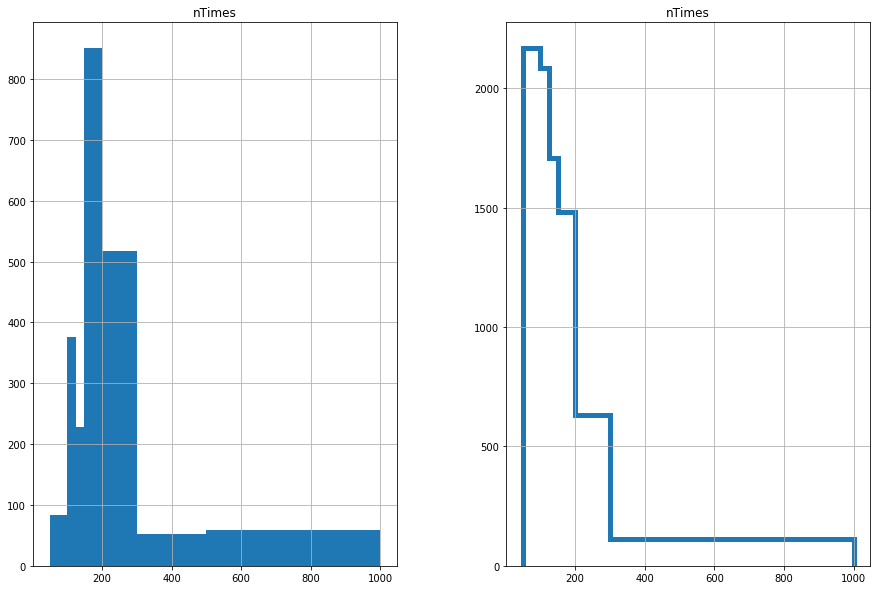

In [8]:
# Data exploration

df = create_ml_csv()
# plot ntimes to check what to include
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
df.hist(column='nTimes', bins=[50, 100, 125, 150, 200, 300, 500, 1000], ax=axes[0])
df.hist(column='nTimes', cumulative=-1, bins=[50, 100, 125, 150, 200, 300, 1000], linewidth=5, histtype='step', ax=axes[1])
#df_input_data['nTimes'].plot.kde()

In [10]:
xx=datasets.fetch_atlas_aal()

In [13]:
xx=datasets.fetch_atlas_harvard_oxford(atlas_name='cort-maxprob-thr25-2mm')

In [15]:
len(xx.labels)

49